In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

#
DATASET AND EDA

In [2]:
#Seed 
seed = 7
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#dataset
data = pd.read_excel("FullDayWithAlarms.xlsx")

since the original excel file had the headers of the columns as the first row

In [4]:
#first row to header 
data.columns = data.iloc[0]
data = data.drop(0).reset_index(drop=True)

set data ora as datetime and set to int all the columns that dont need to be float

In [5]:
#TYPES 
data['DATA ORA'] = pd.to_datetime(data['DATA ORA'])
data['INTERVALLO\nACQUISIZIONE'] = data['INTERVALLO\nACQUISIZIONE'].astype(int)
data['NUMERO\nTRANSAZIONI'] = data['NUMERO\nTRANSAZIONI'].astype(int)
data['TEMPO MIN'] = data['TEMPO MIN'].astype(int)
data['TEMPO MAX'] = data['TEMPO MAX'].astype(int)
data['TEMPO MEDIO'] = data['TEMPO MEDIO'].astype(float)
data['NUMERO RETRY'] = data['NUMERO RETRY'].astype(int)
data['NUMERO \nTRANSAZIONI ERRATE'] = data['NUMERO \nTRANSAZIONI ERRATE'].astype(int)

Correlation matrix

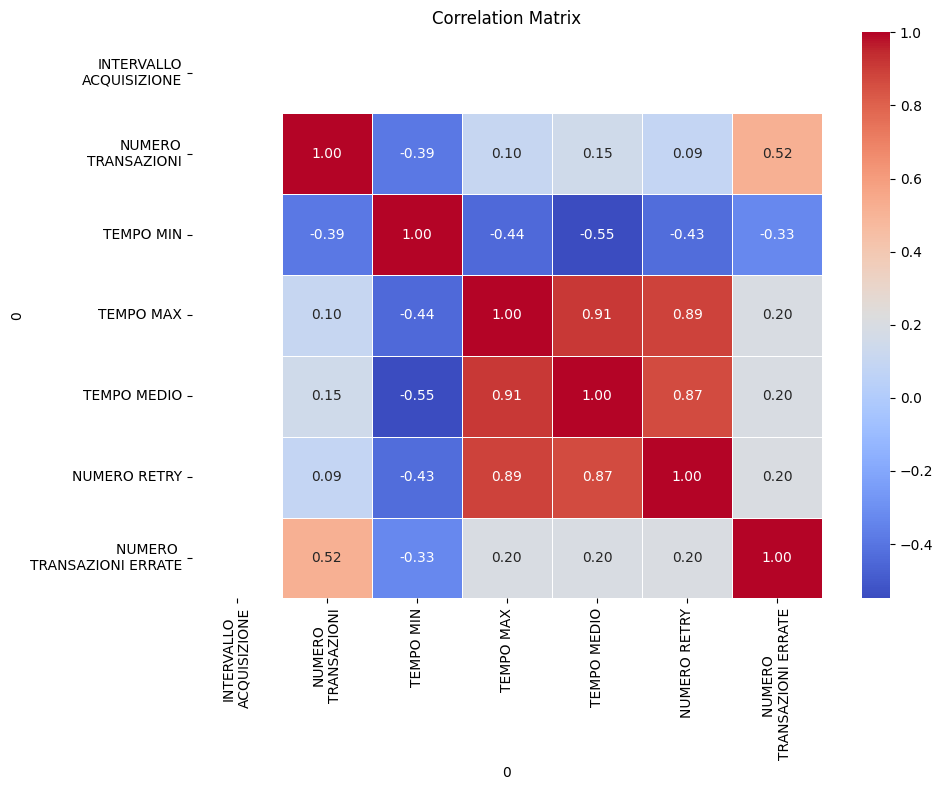

In [ ]:
correlation_matrix = data[['INTERVALLO\nACQUISIZIONE',
                          'NUMERO\nTRANSAZIONI',
                          'TEMPO MIN',
                          'TEMPO MAX',
                          'TEMPO MEDIO',
                          'NUMERO RETRY',
                          'NUMERO \nTRANSAZIONI ERRATE']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

plotting distribution of data ora vs numero transazioni. since we are mainly focusing on it

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


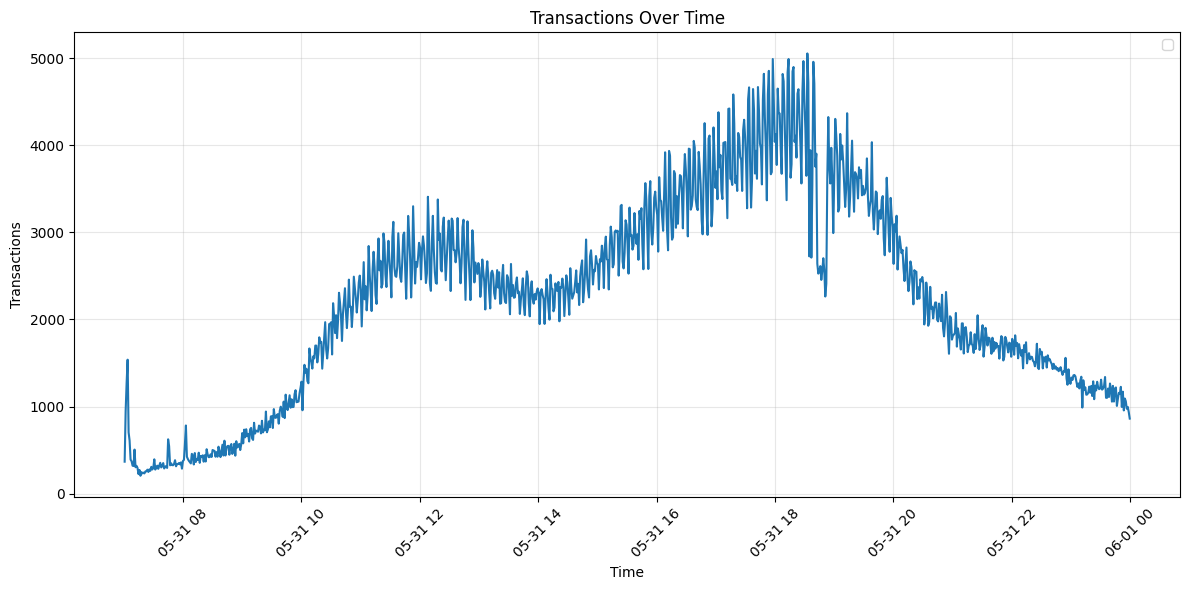

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['DATA ORA'], data['NUMERO\nTRANSAZIONI'], linestyle='-', markersize=4)
plt.title('Transactions Over Time')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

DISTRIBUTIONS

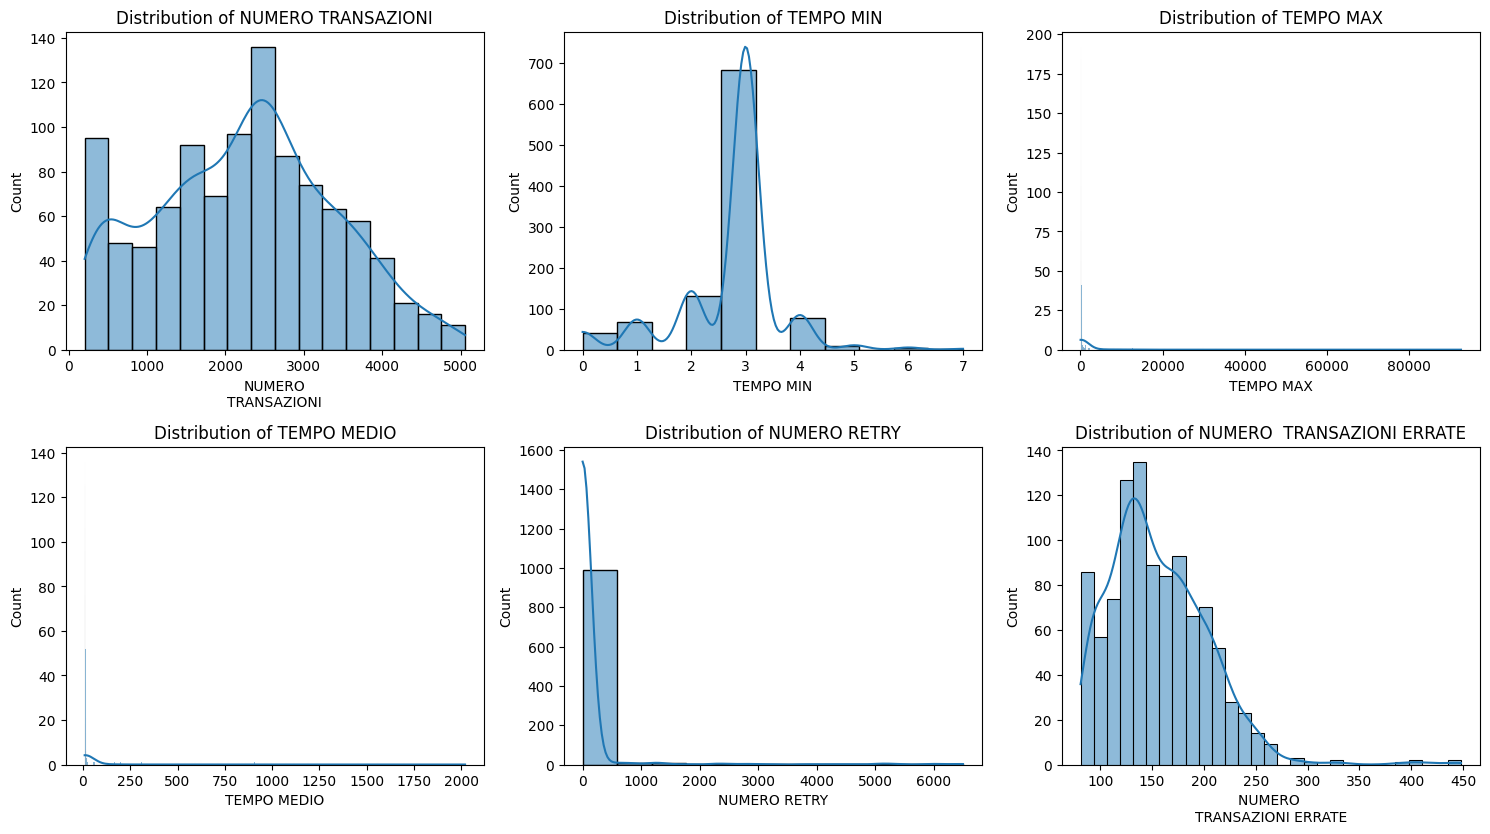

In [7]:
features = [
    'NUMERO\nTRANSAZIONI',
    'TEMPO MIN',
    'TEMPO MAX',
    'TEMPO MEDIO',
    'NUMERO RETRY',
    'NUMERO \nTRANSAZIONI ERRATE'
]
plt.figure(figsize=(15, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[feature], kde=True)
    clean_feature = feature.replace('\n', ' ')
    plt.title(f'Distribution of {clean_feature}')

plt.tight_layout()
plt.show()

#
AUGMENTATION USING VAE

### 
Model

split data ora into day, hour, minute so that the vae will be more accurate when predicting the minutes

In [8]:
#split date into hour, minute, and day
data['hour'] = data['DATA ORA'].dt.hour
data['minute'] = data['DATA ORA'].dt.minute
data['day_of_week'] = data['DATA ORA'].dt.dayofweek

- selecting all the features
- used a lot (5) layers + dropout in encoder and decoder. playing around we found out that this combination worked out the best when (0.1 * kl_loss)
- used reparametrize (sample from the latent space) so that the vae will learn the probability distribution
- for the loss we used (mse_loss + 0.1 * kl_loss) , we tried to multiply the Kullback-Leibler loss with higher values but the vae still did not learn properly how to handle the single minutes so we decided to keep it multiplied by 0.1 and then later hard code the column data ora
- LOWER THE NUMBER OF EPOCHS if you are running on a laptop.


In [9]:
features = [
    'INTERVALLO\nACQUISIZIONE',
    'NUMERO\nTRANSAZIONI',
    'TEMPO MIN',
    'TEMPO MAX',
    'TEMPO MEDIO',
    'NUMERO RETRY',
    'NUMERO \nTRANSAZIONI ERRATE',
    'hour',
    'minute'
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

#model
class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(len(features),)),
            layers.Dropout(0.2),
            layers.Dense(96, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(latent_dim,)),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(96, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(features))
        ])
    def encode(self, x):
        mean_log_var = self.encoder(x)
        mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
        return mean, log_var
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return mean + tf.exp(log_var * 0.5) * eps
    def decode(self, z):
        return self.decoder(z)
latent_dim = 5
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

#loss function
def vae_loss(x, reconstruction, z_mean, z_log_var):
    mse_loss = tf.reduce_mean(tf.square(x - reconstruction))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return mse_loss + 0.1 * kl_loss

epochs = 150
batch_size = 32

for epoch in range(epochs):
    indices = np.random.permutation(len(scaled_data))
    for i in range(0, len(scaled_data), batch_size):
        batch_indices = indices[i:min(i + batch_size, len(scaled_data))]
        x_batch = tf.convert_to_tensor(scaled_data[batch_indices], dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = vae.encode(x_batch)
            z = vae.reparameterize(z_mean, z_log_var)
            reconstruction = vae.decode(z)
            loss = vae_loss(x_batch, reconstruction, z_mean, z_log_var)
        
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")


Epoch 10/150, Loss: 0.19414901733398438
Epoch 20/150, Loss: 0.16122326254844666
Epoch 30/150, Loss: 0.15527385473251343
Epoch 40/150, Loss: 0.16226278245449066
Epoch 50/150, Loss: 0.17103469371795654
Epoch 60/150, Loss: 0.24463772773742676
Epoch 70/150, Loss: 0.15770599246025085
Epoch 80/150, Loss: 0.16156244277954102
Epoch 90/150, Loss: 0.15941959619522095
Epoch 100/150, Loss: 0.1690811663866043
Epoch 110/150, Loss: 0.1626385748386383
Epoch 120/150, Loss: 0.14852488040924072
Epoch 130/150, Loss: 0.14093303680419922
Epoch 140/150, Loss: 0.15191516280174255
Epoch 150/150, Loss: 0.15054410696029663


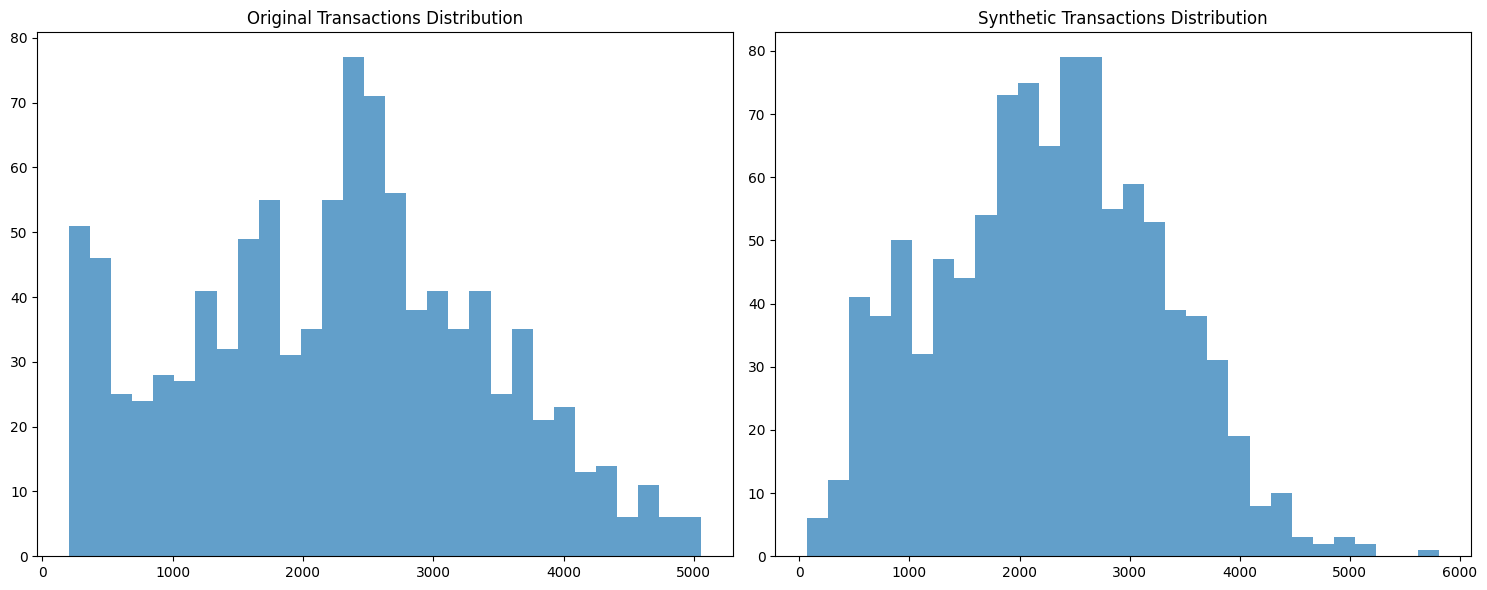

In [10]:
#data generation
n_samples = len(data)
z = tf.random.normal((n_samples, latent_dim))
generated_data = vae.decode(z).numpy()
generated_scaled = generated_data
generated_df = pd.DataFrame(scaler.inverse_transform(generated_scaled), columns=features)

#Proper DATA ORA 
base_date = data['DATA ORA'].min().date()
#Clip between 7 and 23
generated_df['hour'] = generated_df['hour'].clip(7, 23).round().astype(int)
generated_df['minute'] = generated_df['minute'].clip(0, 59).round().astype(int)
generated_df['DATA ORA'] = pd.to_datetime(
    pd.Series([base_date] * n_samples).astype(str) + ' ' + 
    generated_df['hour'].astype(str) + ':' + 
    generated_df['minute'].astype(str) + ':00'
)
#round and clip + addition of COD GIOCO
dataset_syn = generated_df.copy()
for col in ['INTERVALLO\nACQUISIZIONE', 'NUMERO\nTRANSAZIONI', 'TEMPO MIN', 
           'TEMPO MAX', 'NUMERO RETRY', 'NUMERO \nTRANSAZIONI ERRATE']:
    dataset_syn[col] = dataset_syn[col].round().astype(int).clip(0)
dataset_syn['COD \nGIOCO'] = data['COD \nGIOCO'].iloc[0]

#ordering
final_columns = ['COD \nGIOCO', 'DATA ORA', 'INTERVALLO\nACQUISIZIONE', 'NUMERO\nTRANSAZIONI',
                'TEMPO MIN', 'TEMPO MAX', 'TEMPO MEDIO', 'NUMERO RETRY', 'NUMERO \nTRANSAZIONI ERRATE']
dataset_syn = dataset_syn[final_columns]

# Compare distributions
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.hist(data['NUMERO\nTRANSAZIONI'], bins=30, alpha=0.7)
plt.title('Original Transactions Distribution')
plt.subplot(1, 2, 2)
plt.hist(dataset_syn['NUMERO\nTRANSAZIONI'], bins=30, alpha=0.7)
plt.title('Synthetic Transactions Distribution')
plt.tight_layout()
plt.show()

###
creation of 5 datasets that will be used to "lower the variance"

here we simply generate 5 datasets called datasets_synsets and "clean them" with the same process we did above (everything is explained in the comments)

In [11]:
dataset_synsets = []
for i in range(5):
    z = tf.random.normal((n_samples, latent_dim))
    generated_data = vae.decode(z).numpy()
    generated_scaled = generated_data
    generated_df = pd.DataFrame(scaler.inverse_transform(generated_scaled), columns=features)
    
    #same clipping as cell above 7 - 24
    generated_df['hour'] = generated_df['hour'].clip(7, 23).round().astype(int)
    generated_df['minute'] = generated_df['minute'].clip(0, 59).round().astype(int)
    generated_df['DATA ORA'] = pd.to_datetime(
        pd.Series([base_date] * n_samples).astype(str) + ' ' + 
        generated_df['hour'].astype(str) + ':' + 
        generated_df['minute'].astype(str) + ':00'
    )
    #Same round and clip + addition of COD GIOCO as above
    dataset_syn_i = generated_df.copy()
    for col in ['INTERVALLO\nACQUISIZIONE', 'NUMERO\nTRANSAZIONI', 'TEMPO MIN', 
                'TEMPO MAX', 'NUMERO RETRY', 'NUMERO \nTRANSAZIONI ERRATE']:
        dataset_syn_i[col] = dataset_syn_i[col].round().astype(int).clip(0)
    dataset_syn_i['COD \nGIOCO'] = data['COD \nGIOCO'].iloc[0]
    dataset_syn_i = dataset_syn_i[final_columns]
    dataset_synsets.append(dataset_syn_i)

In [12]:
#Sort by DATA ORA all our dataframes just to be sure
data = data.sort_values(by='DATA ORA').reset_index(drop=True)
dataset_syn = dataset_syn.sort_values(by='DATA ORA').reset_index(drop=True)
dataset_synsets = [sd.sort_values(by='DATA ORA').reset_index(drop=True) for sd in dataset_synsets]

###
Hard Coding DATA ORA into predicitons

In [13]:
#Change DATA ORA to the Original data (to fix the fact that our vae did not generate exactly one row per minute)
dataset_syn['DATA ORA'] = data['DATA ORA']
dataset_synsets[0]['DATA ORA'] = data['DATA ORA']
dataset_synsets[1]['DATA ORA'] = data['DATA ORA']
dataset_synsets[2]['DATA ORA'] = data['DATA ORA']
dataset_synsets[3]['DATA ORA'] = data['DATA ORA']
dataset_synsets[4]['DATA ORA'] = data['DATA ORA']

In [14]:
#forgot to round the minutes
dataset_syn['DATA ORA'] = dataset_syn['DATA ORA'].dt.floor('T')
dataset_synsets[0]['DATA ORA'] = dataset_synsets[0]['DATA ORA'].dt.floor('T')
dataset_synsets[1]['DATA ORA'] = dataset_synsets[1]['DATA ORA'].dt.floor('T')
dataset_synsets[2]['DATA ORA'] = dataset_synsets[2]['DATA ORA'].dt.floor('T')
dataset_synsets[3]['DATA ORA'] = dataset_synsets[3]['DATA ORA'].dt.floor('T')
dataset_synsets[4]['DATA ORA'] = dataset_synsets[4]['DATA ORA'].dt.floor('T')

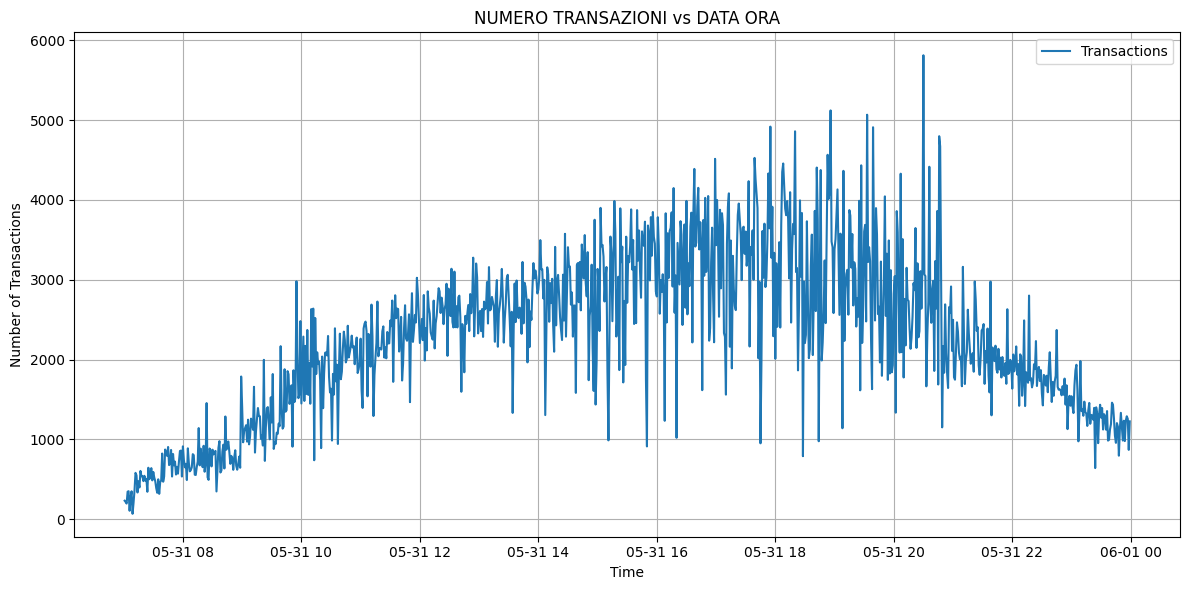

In [ ]:
#distribution of numero transazioni overtime of on of the synthetic datasets
plt.figure(figsize=(12, 6))
plt.plot(dataset_synsets[1]['DATA ORA'], dataset_syn['NUMERO\nTRANSAZIONI'], label='Transactions')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('NUMERO TRANSAZIONI vs DATA ORA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##
lowering the noise of our synthetic datasets by computing the average from these 5 creating a new dataframe

first creating a combined data with all the transactions and then computing the mean

In [16]:
#mean of NUMERO TRANSAZIONI to "lower the noise"
lista = []
for dataset in dataset_synsets:
    extracted = dataset[['DATA ORA', 'NUMERO\nTRANSAZIONI']]
    lista.append(extracted)
combined_data = pd.concat(lista)

avg = combined_data.groupby('DATA ORA')['NUMERO\nTRANSAZIONI'].mean().reset_index()
avg.rename(columns={'NUMERO\nTRANSAZIONI': 'AVG_TRANSACTIONS'}, inplace=True)
avg = avg.sort_values('DATA ORA')

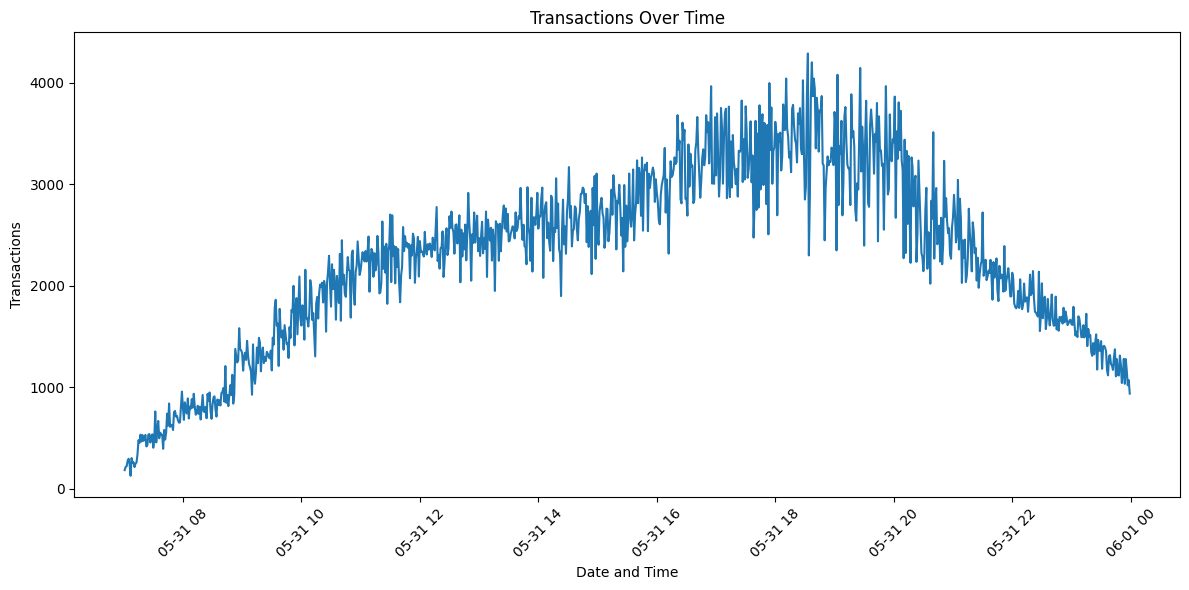

In [17]:
#plot to check the actual distribution overtime
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg, x='DATA ORA', y='AVG_TRANSACTIONS')
plt.xlabel('Date and Time')
plt.ylabel('Transactions')
plt.title('Transactions Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
#replacing,sorting DATA ORA and round
dataset_syn = dataset_syn.sort_values(by='DATA ORA').reset_index(drop=True)
avg = avg.sort_values(by='DATA ORA').reset_index(drop=True)
avg_map = dict(zip(avg['DATA ORA'], avg['AVG_TRANSACTIONS']))
mask = dataset_syn['DATA ORA'].isin(avg['DATA ORA'])
dataset_syn.loc[mask, 'NUMERO\nTRANSAZIONI'] = dataset_syn.loc[mask, 'DATA ORA'].map(avg_map)
dataset_syn['NUMERO\nTRANSAZIONI'] = dataset_syn['NUMERO\nTRANSAZIONI'].round().astype(int)
dataset_syn.head()

,COD \nGIOCO,DATA ORA,INTERVALLO\nACQUISIZIONE,NUMERO\nTRANSAZIONI,TEMPO MIN,TEMPO MAX,TEMPO MEDIO,NUMERO RETRY,NUMERO \nTRANSAZIONI ERRATE
0,8,2024-05-31 07:01:00,60,185,4,0,12.256021,45,85
1,8,2024-05-31 07:02:00,60,217,4,64,8.628415,50,83
2,8,2024-05-31 07:03:00,60,223,4,353,12.590669,87,78
3,8,2024-05-31 07:04:00,60,277,5,0,20.421131,7,103
4,8,2024-05-31 07:05:00,60,297,4,0,13.564816,39,87


check if the dataset augmented is actually good

checking if the correlation matrix is still similar to the starting one. and its 

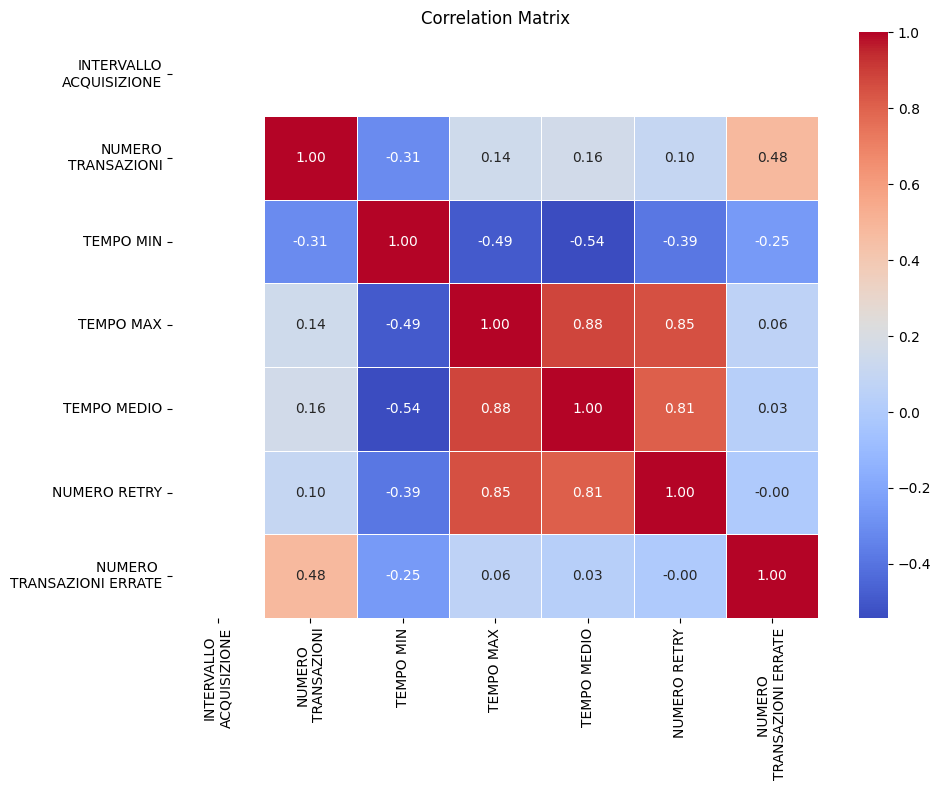

In [19]:
#corr matrix 
correlation_matrix = dataset_syn[['INTERVALLO\nACQUISIZIONE',
                          'NUMERO\nTRANSAZIONI',
                          'TEMPO MIN',
                          'TEMPO MAX',
                          'TEMPO MEDIO',
                          'NUMERO RETRY',
                          'NUMERO \nTRANSAZIONI ERRATE']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

END OF AUGMENTATION

#
FORECASTING + Simple Anomaly detection of Actual vs Forecast. 

##
LSTM model

- start time 16:00
- decided to use as predictors Numero transazioni, Numero transazioni errate, Numero retry and Tempo max(since all the other "tempo" variables were highly correlated between eachother and this might lead to multicollinarity even if we think that the lstm will just handle it fine)
- used MinMaxScaler because we do not want negative values
- input sequence 60 minutes predicting the next 15 minutes
- we used only one day of data because when we tried adding more the RMSE was increasing (we think its beacause our augmentation process is not that "solid")

In [20]:
#definizione start time (16:00)
start_time = pd.Timestamp('2024-05-31 16:00:00')
data_for_model = dataset_syn[dataset_syn['DATA ORA'].dt.hour >= 16].copy()
data_for_model = data_for_model.sort_values(by='DATA ORA').reset_index(drop=True)

#columns to use
features = ['NUMERO\nTRANSAZIONI', 'NUMERO \nTRANSAZIONI ERRATE', 'NUMERO RETRY', 'TEMPO MAX']
target = 'NUMERO\nTRANSAZIONI'

#scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_data = feature_scaler.fit_transform(data_for_model[features])
y_data = target_scaler.fit_transform(data_for_model[[target]])

#Sequence (input 60 min , output 15 min)
def create_sequences(X, y, input_len=60, output_len=15):
    X_seq, y_seq = [], []
    for i in range(len(X) - input_len - output_len + 1):
        X_seq.append(X[i:i+input_len])
        y_seq.append(y[i+input_len:i+input_len+output_len, 0])
    return np.array(X_seq), np.array(y_seq)
X, y = create_sequences(X_data, y_data)

#split 80/20
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

- simple model with 3 layers + 2 dropout (to prevent overfitting , even without dropout it should not overfit since we only used 1 day of data)
- added early stopping with patience of 10 epochs

Epoch 1/100
11/11 [==============================] - 3s 74ms/step - loss: 0.4886 - val_loss: 0.1288
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 0.2948 - val_loss: 0.1496
Epoch 3/100
11/11 [==============================] - 0s 25ms/step - loss: 0.2187 - val_loss: 0.1470
Epoch 4/100
11/11 [==============================] - 0s 25ms/step - loss: 0.1862 - val_loss: 0.0676
Epoch 5/100
11/11 [==============================] - 0s 25ms/step - loss: 0.1642 - val_loss: 0.0393
Epoch 6/100
11/11 [==============================] - 0s 24ms/step - loss: 0.1497 - val_loss: 0.0338
Epoch 7/100
11/11 [==============================] - 0s 25ms/step - loss: 0.1406 - val_loss: 0.0370
Epoch 8/100
11/11 [==============================] - 0s 24ms/step - loss: 0.1464 - val_loss: 0.0357
Epoch 9/100
11/11 [==============================] - 0s 24ms/step - loss: 0.1446 - val_loss: 0.0310
Epoch 10/100
11/11 [==============================] - 0s 24ms/step - loss: 0.1309 - val_loss: 0.0319

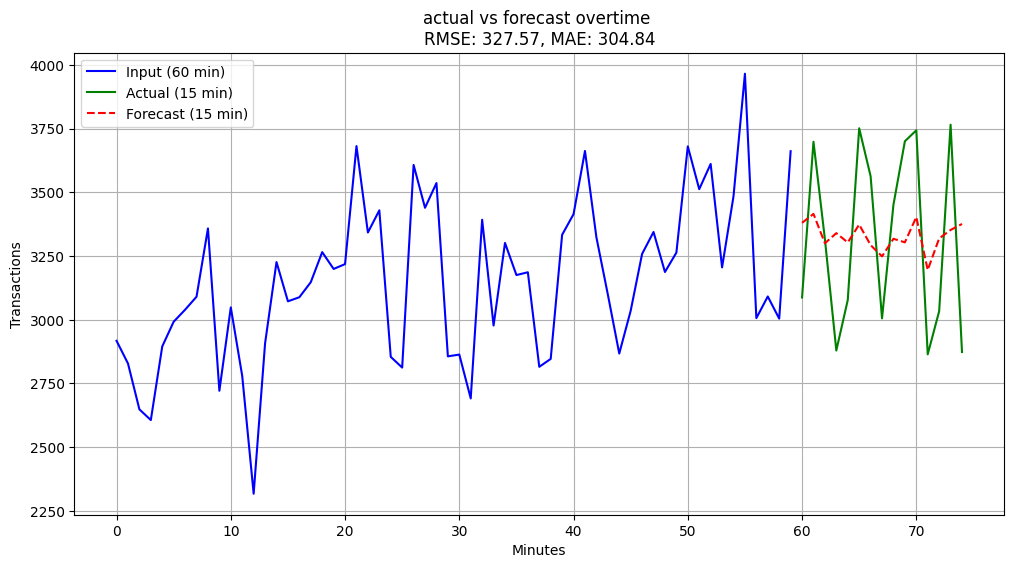

In [21]:
#model
model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(60, len(features))),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(15)
])

#optimizer and loss
model.compile(optimizer='adam', loss='mae')

#train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)
#time window (from 16:00 to 17:00)
window_idx = data_for_model[data_for_model['DATA ORA'].dt.hour == 16].index[0]
window = X_data[window_idx:window_idx+60].reshape(1, 60, len(features))
#forecast
forecast_scaled = model.predict(window)[0]
forecast = target_scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
#actual
actuals = data_for_model.iloc[window_idx+60:window_idx+75][target].values
    
#metrics
mse = mean_squared_error(actuals, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, forecast)
#actual vs forecast overtime
plt.figure(figsize=(12, 6))
plt.plot(range(60), data_for_model.iloc[window_idx:window_idx+60][target].values,label='Input (60 min)', color='blue')
plt.plot(range(60, 75), actuals, label='Actual (15 min)', color='green')
plt.plot(range(60, 75), forecast, label='Forecast (15 min)', color='red', linestyle='--')
plt.title(f'actual vs forecast overtime \nRMSE: {rmse:.2f}, MAE: {mae:.2f}')
plt.xlabel('Minutes')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.show()

considering we start with a very shaky distribution the forecast looks pretty good.

###
creation of a dataframe that has the forecast in it so that later we can compute the moving average

In [22]:
#creation of a df that contains the forecasted values + errors
DataOrariForecast = pd.date_range(start=data_for_model.iloc[window_idx+60]['DATA ORA'], periods=15, freq='1min')
forecast_df = pd.DataFrame({
        'DATA ORA': DataOrariForecast,
        'Forecast': forecast.round().astype(int),
        'Actual': actuals,
        'Error': abs(forecast.round() - actuals)
    })
forecast_df.head(15)

,DATA ORA,Forecast,Actual,Error
0,2024-05-31 17:00:00,3380,3087,293.0
1,2024-05-31 17:01:00,3415,3698,283.0
2,2024-05-31 17:02:00,3300,3316,16.0
3,2024-05-31 17:03:00,3339,2879,460.0
4,2024-05-31 17:04:00,3303,3077,226.0
5,2024-05-31 17:05:00,3373,3751,378.0
6,2024-05-31 17:06:00,3293,3563,270.0
7,2024-05-31 17:07:00,3248,3005,243.0
8,2024-05-31 17:08:00,3317,3451,134.0
9,2024-05-31 17:09:00,3303,3700,397.0


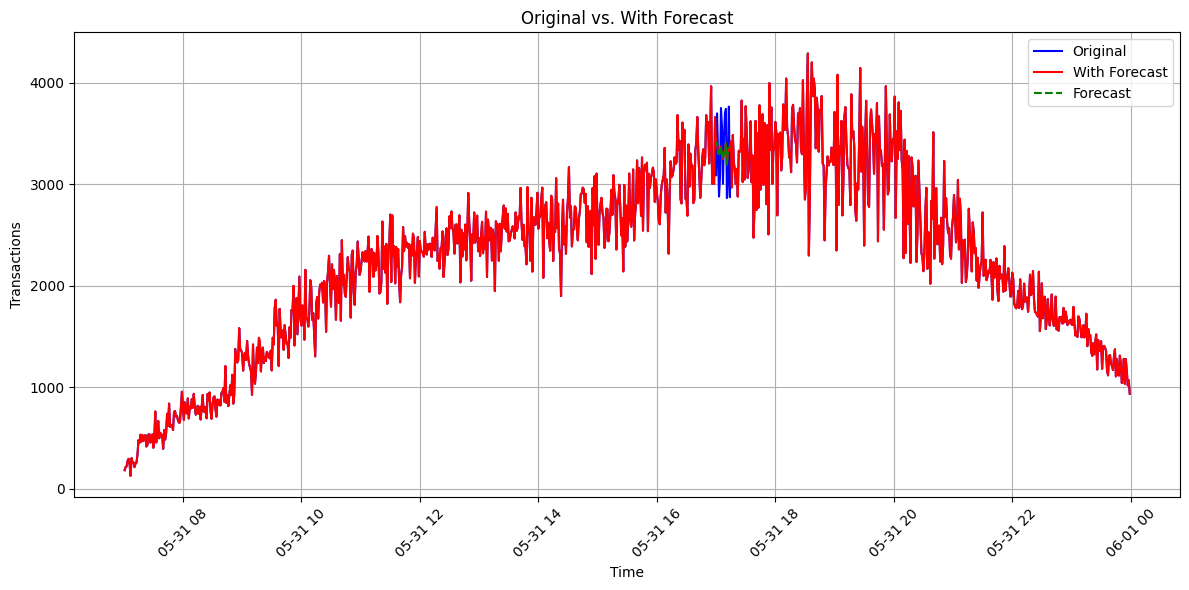

In [23]:
#creating a new dataframe that contains the forecast and then comparing the two
dataset_syn_with_forecast = dataset_syn.copy()
mask = dataset_syn_with_forecast['DATA ORA'].isin(forecast_df['DATA ORA'])
forecast_map = dict(zip(forecast_df['DATA ORA'], forecast_df['Forecast']))
dataset_syn_with_forecast.loc[mask, 'NUMERO\nTRANSAZIONI'] = dataset_syn_with_forecast.loc[mask, 'DATA ORA'].map(forecast_map)

#er plot
plt.figure(figsize=(12, 6))
plt.plot(dataset_syn['DATA ORA'], dataset_syn['NUMERO\nTRANSAZIONI'], label='Original', color='blue')
plt.plot(dataset_syn_with_forecast['DATA ORA'], dataset_syn_with_forecast['NUMERO\nTRANSAZIONI'], label='With Forecast', color='red')
plt.plot(forecast_df['DATA ORA'], forecast_df['Forecast'], label='Forecast', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.title('Original vs. With Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###
Moving average (5 minutes)

computing the moving average over 5 minutes and comparing the "original" distribution with the "forecast" one. 
When the line cross and when the |error| > 100 then we have an anomaly

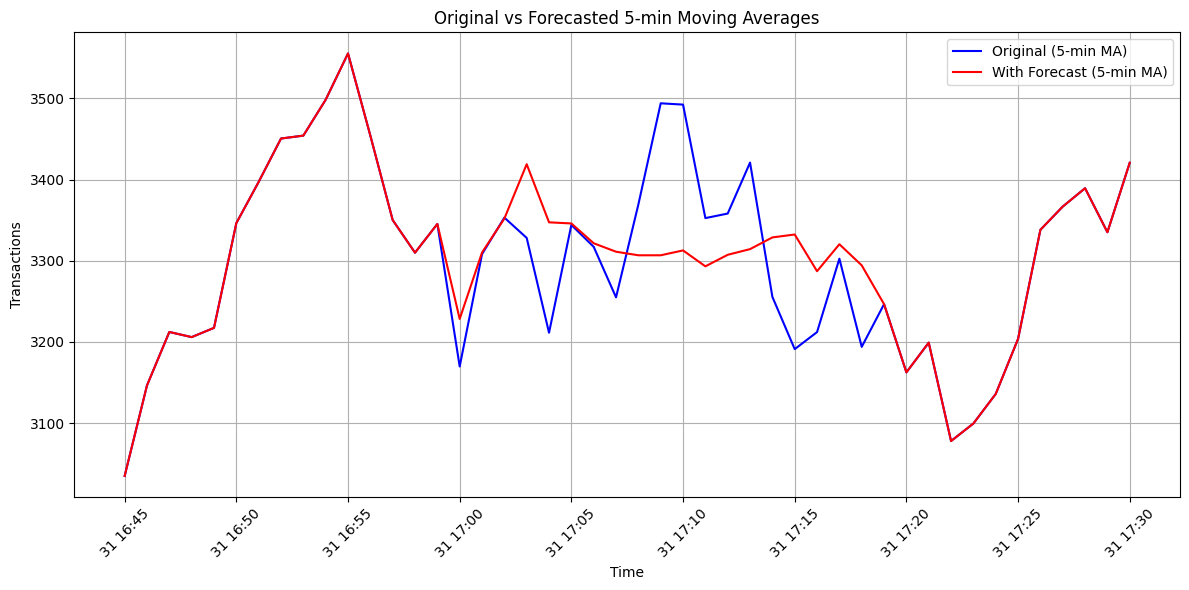

In [24]:
#select a time window too zoom in
start_time = pd.Timestamp('2024-05-31 16:45:00')
end_time = pd.Timestamp('2024-05-31 17:30:00')
zoom_original = dataset_syn[(dataset_syn['DATA ORA'] >= start_time) & 
                                  (dataset_syn['DATA ORA'] <= end_time)].copy()                                 
zoom_forecast = dataset_syn_with_forecast[(dataset_syn_with_forecast['DATA ORA'] >= start_time) & 
                                               (dataset_syn_with_forecast['DATA ORA'] <= end_time)].copy()
data_for_model = data[(data['DATA ORA'] >= start_time) &
                     (data['DATA ORA'] <= end_time)].copy()
#Moving average 5 minutes
data_for_model['MA_15'] = data_for_model['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()
zoom_original['MA_15'] = zoom_original['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()
zoom_forecast['MA_15'] = zoom_forecast['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()

#creation of error and cross
zoom_original['MA_Error'] = zoom_original['MA_15'] - zoom_forecast['MA_15']
# Calculate if the current point has a positive error and the previous point has a negative error
zoom_original['MA_Error_Shift'] = zoom_original['MA_Error'].shift(1)
zoom_original['Cross'] = (
    ((zoom_original['MA_Error_Shift'] < 0) & (zoom_original['MA_Error'] > 0)) | 
    ((zoom_original['MA_Error_Shift'] > 0) & (zoom_original['MA_Error'] < 0))
).astype(int)
#0 to first point otherwise cross does not work
zoom_original['Cross'].iloc[0] = 0

#plot ma
plt.figure(figsize=(12, 6))
plt.plot(zoom_original['DATA ORA'], zoom_original['MA_15'], label='Original (5-min MA)', color='blue')
plt.plot(zoom_forecast['DATA ORA'], zoom_forecast['MA_15'], label='With Forecast (5-min MA)', color='red')

#Add green X markers for points with error > 100
high_error_points = zoom_original[(abs(zoom_original['MA_Error']) > 100) & (zoom_original['Cross'] == 1)]
if not high_error_points.empty:
    plt.scatter(high_error_points['DATA ORA'], high_error_points['MA_15'], 
                marker='x', color='green', s=100, linewidth=2, 
                label='|Error| > 100')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.title('Original vs Forecasted 5-min Moving Averages')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##
Another model this time with a different time(18:00)- ALL the steps are the same as above

its another model with a different time, the code is the same as above but this time we have an anomaly at the end (if you run the vae with lower epochs then the results of the forecast might change so you might not see the anomalies)

In [25]:
#definizione start time (18:00)
start_time = pd.Timestamp('2024-05-31 18:00:00')
data_for_model = dataset_syn[dataset_syn['DATA ORA'].dt.hour >= 18].copy()
data_for_model = data_for_model.sort_values(by='DATA ORA').reset_index(drop=True)

#columns to use
features = ['NUMERO\nTRANSAZIONI', 'NUMERO \nTRANSAZIONI ERRATE', 'NUMERO RETRY', 'TEMPO MAX']
target = 'NUMERO\nTRANSAZIONI'

#scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_data = feature_scaler.fit_transform(data_for_model[features])
y_data = target_scaler.fit_transform(data_for_model[[target]])

#Sequence (input 60 min , output 15 min)
def create_sequences(X, y, input_len=60, output_len=15):
    X_seq, y_seq = [], []
    for i in range(len(X) - input_len - output_len + 1):
        X_seq.append(X[i:i+input_len])
        y_seq.append(y[i+input_len:i+input_len+output_len, 0])
    return np.array(X_seq), np.array(y_seq)
X, y = create_sequences(X_data, y_data)

#split 80/20
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

Epoch 1/100
8/8 [==============================] - 3s 104ms/step - loss: 0.3515 - val_loss: 0.1141
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 0.2093 - val_loss: 0.1044
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 0.1644 - val_loss: 0.0746
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.1410 - val_loss: 0.0766
Epoch 5/100
8/8 [==============================] - 0s 32ms/step - loss: 0.1326 - val_loss: 0.0352
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 0.1167 - val_loss: 0.0315
Epoch 7/100
8/8 [==============================] - 0s 30ms/step - loss: 0.1154 - val_loss: 0.0306
Epoch 8/100
8/8 [==============================] - 0s 30ms/step - loss: 0.1157 - val_loss: 0.0320
Epoch 9/100
8/8 [==============================] - 0s 29ms/step - loss: 0.1037 - val_loss: 0.0361
Epoch 10/100
8/8 [==============================] - 0s 28ms/step - loss: 0.1077 - val_loss: 0.0395
Epoch 11/100
8/8 [

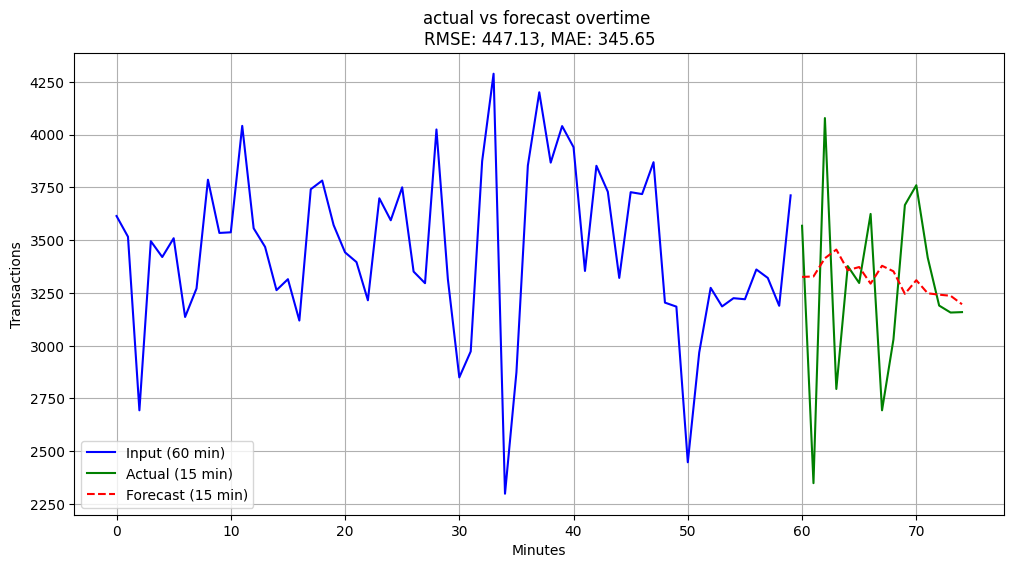

In [26]:
#model
model = tf.keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(60, len(features))),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(15)
])

#optimizer and loss
model.compile(optimizer='adam', loss='mae')

#train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)
#time window (from 16:00 to 17:00)
window_idx = data_for_model[data_for_model['DATA ORA'].dt.hour == 18].index[0]
window = X_data[window_idx:window_idx+60].reshape(1, 60, len(features))
#forecast
forecast_scaled = model.predict(window)[0]
forecast = target_scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
#actual
actuals = data_for_model.iloc[window_idx+60:window_idx+75][target].values
    
#metrics
mse = mean_squared_error(actuals, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, forecast)
#actual vs forecast overtime
plt.figure(figsize=(12, 6))
plt.plot(range(60), data_for_model.iloc[window_idx:window_idx+60][target].values,label='Input (60 min)', color='blue')
plt.plot(range(60, 75), actuals, label='Actual (15 min)', color='green')
plt.plot(range(60, 75), forecast, label='Forecast (15 min)', color='red', linestyle='--')
plt.title(f'actual vs forecast overtime \nRMSE: {rmse:.2f}, MAE: {mae:.2f}')
plt.xlabel('Minutes')
plt.ylabel('Transactions')
plt.legend()
plt.grid(True)
plt.show()

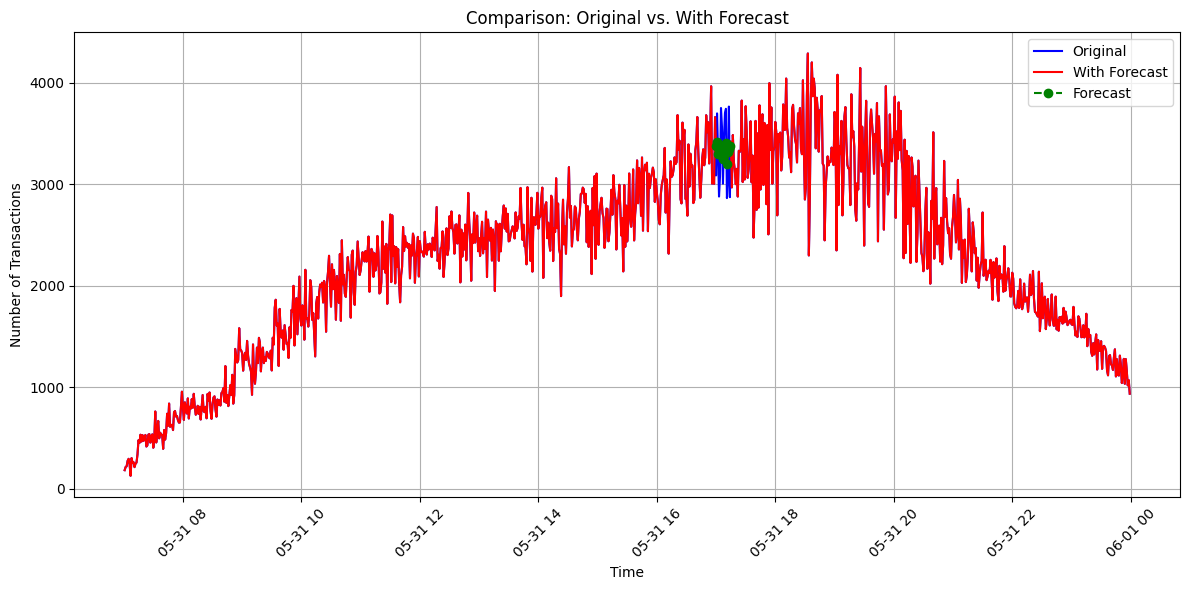

In [27]:
# Create a copy of the synthetic data
dataset_syn_with_forecast = dataset_syn.copy()

# Find the rows in dataset_syn_with_forecast that match the forecast times
mask = dataset_syn_with_forecast['DATA ORA'].isin(forecast_df['DATA ORA'])

# Replace the 'NUMERO\nTRANSAZIONI' values with the forecasted values
forecast_map = dict(zip(forecast_df['DATA ORA'], forecast_df['Forecast']))
dataset_syn_with_forecast.loc[mask, 'NUMERO\nTRANSAZIONI'] = dataset_syn_with_forecast.loc[mask, 'DATA ORA'].map(forecast_map)

# Visualize the original vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(dataset_syn['DATA ORA'], dataset_syn['NUMERO\nTRANSAZIONI'], label='Original', color='blue')
plt.plot(dataset_syn_with_forecast['DATA ORA'], dataset_syn_with_forecast['NUMERO\nTRANSAZIONI'], label='With Forecast', color='red')
plt.plot(forecast_df['DATA ORA'], forecast_df['Forecast'], label='Forecast', color='green', linestyle='--', marker='o')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.title('Comparison: Original vs. With Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
#creation of a df that contains the forecasted values + errors
DataOrariForecast = pd.date_range(start=data_for_model.iloc[window_idx+60]['DATA ORA'], periods=15, freq='1min')
forecast_df = pd.DataFrame({
        'DATA ORA': DataOrariForecast,
        'Forecast': forecast.round().astype(int),
        'Actual': actuals,
        'Error': abs(forecast.round() - actuals)
    })
forecast_df.head(15)

,DATA ORA,Forecast,Actual,Error
0,2024-05-31 19:01:00,3326,3568,242.0
1,2024-05-31 19:02:00,3328,2349,979.0
2,2024-05-31 19:03:00,3414,4078,664.0
3,2024-05-31 19:04:00,3455,2795,660.0
4,2024-05-31 19:05:00,3357,3377,20.0
5,2024-05-31 19:06:00,3373,3297,76.0
6,2024-05-31 19:07:00,3294,3624,330.0
7,2024-05-31 19:08:00,3379,2694,685.0
8,2024-05-31 19:09:00,3352,3030,322.0
9,2024-05-31 19:10:00,3245,3666,421.0


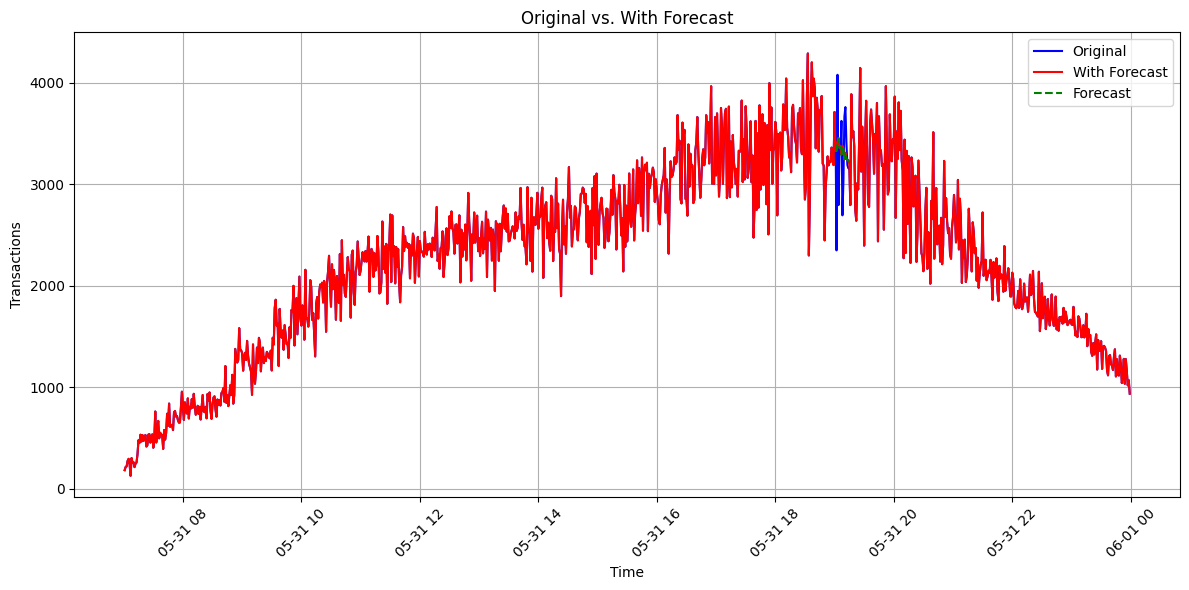

In [29]:
#creating a new dataframe that contains the forecast and then comparing the two
dataset_syn_with_forecast = dataset_syn.copy()
mask = dataset_syn_with_forecast['DATA ORA'].isin(forecast_df['DATA ORA'])
forecast_map = dict(zip(forecast_df['DATA ORA'], forecast_df['Forecast']))
dataset_syn_with_forecast.loc[mask, 'NUMERO\nTRANSAZIONI'] = dataset_syn_with_forecast.loc[mask, 'DATA ORA'].map(forecast_map)

#er plot
plt.figure(figsize=(12, 6))
plt.plot(dataset_syn['DATA ORA'], dataset_syn['NUMERO\nTRANSAZIONI'], label='Original', color='blue')
plt.plot(dataset_syn_with_forecast['DATA ORA'], dataset_syn_with_forecast['NUMERO\nTRANSAZIONI'], label='With Forecast', color='red')
plt.plot(forecast_df['DATA ORA'], forecast_df['Forecast'], label='Forecast', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.title('Original vs. With Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

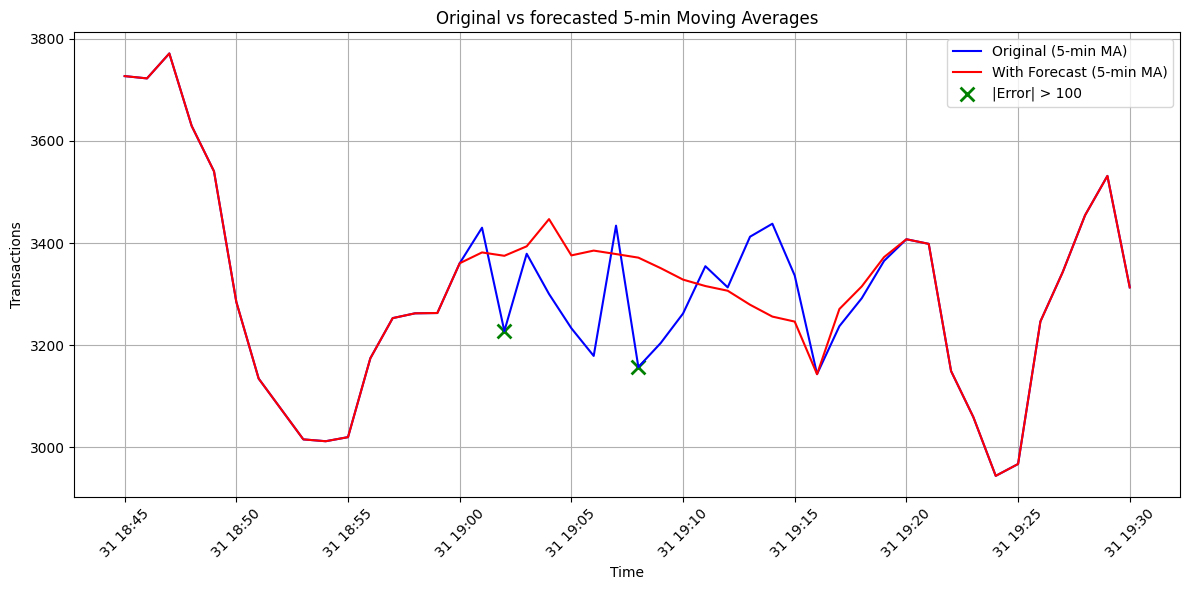

In [30]:
#select a time window too zoom in
start_time = pd.Timestamp('2024-05-31 18:45:00')
end_time = pd.Timestamp('2024-05-31 19:30:00')
zoom_original = dataset_syn[(dataset_syn['DATA ORA'] >= start_time) & 
                                  (dataset_syn['DATA ORA'] <= end_time)].copy()                                 
zoom_forecast = dataset_syn_with_forecast[(dataset_syn_with_forecast['DATA ORA'] >= start_time) & 
                                               (dataset_syn_with_forecast['DATA ORA'] <= end_time)].copy()
data_for_model = data[(data['DATA ORA'] >= start_time) &
                     (data['DATA ORA'] <= end_time)].copy()
#Moving average 5 minutes
data_for_model['MA_15'] = data_for_model['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()
zoom_original['MA_15'] = zoom_original['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()
zoom_forecast['MA_15'] = zoom_forecast['NUMERO\nTRANSAZIONI'].rolling(window=5, min_periods=1).mean()

#creation of error and cross
zoom_original['MA_Error'] = zoom_original['MA_15'] - zoom_forecast['MA_15']
# Calculate if the current point has a positive error and the previous point has a negative error
zoom_original['MA_Error_Shift'] = zoom_original['MA_Error'].shift(1)
zoom_original['Cross'] = (
    ((zoom_original['MA_Error_Shift'] < 0) & (zoom_original['MA_Error'] > 0)) | 
    ((zoom_original['MA_Error_Shift'] > 0) & (zoom_original['MA_Error'] < 0))
).astype(int)
#0 to first point otherwise cross does not work
zoom_original['Cross'].iloc[0] = 0

#plot ma
plt.figure(figsize=(12, 6))
plt.plot(zoom_original['DATA ORA'], zoom_original['MA_15'], label='Original (5-min MA)', color='blue')
plt.plot(zoom_forecast['DATA ORA'], zoom_forecast['MA_15'], label='With Forecast (5-min MA)', color='red')

#Add green X markers for points with error > 100
high_error_points = zoom_original[(abs(zoom_original['MA_Error']) > 100) & (zoom_original['Cross'] == 1)]
if not high_error_points.empty:
    plt.scatter(high_error_points['DATA ORA'], high_error_points['MA_15'], 
                marker='x', color='green', s=100, linewidth=2, 
                label='|Error| > 100')
plt.xlabel('Time')
plt.ylabel('Transactions')
plt.title('Original vs forecasted 5-min Moving Averages')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Isolation Forest
Now we will use Isolation Forest to do some anomaly detection on the Actual and Forecasted values in the 15 minutes forecasted time window. We use also the isolation forest because we want to have also a model finding the anomalies. Also in the above method we didn't use the values but we used the rolling average, so this approach is quite different. We will also plot the the values while highlighting the points that were identified as anomalies. 

In [31]:
df = forecast_df.copy()
actuals = 'Actual' in df.columns
if actuals:
    X = df[['Forecast', 'Actual']].values
    forest = IsolationForest(contamination=0.1, random_state=42)
    df['anomaly'] = forest.fit_predict(X)
    df['anomaly'] = df['anomaly'] == -1
    fig = make_subplots(rows=1, cols=1, 
                        subplot_titles=["Anomaly Detection: Forecast vs Actual"])
    
    fig.add_trace(
        go.Scatter(
            x=df['DATA ORA'],
            y=df['Forecast'],
            mode='lines+markers',
            name='Forecast',
            line=dict(color='blue'),
            marker=dict(size=8)
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=df['DATA ORA'],
            y=df['Actual'],
            mode='lines+markers',
            name='Actual',
            line=dict(color='green'),
            marker=dict(size=8)
        )
    )
    
    anomalies = df[df['anomaly']]
    fig.add_trace(
        go.Scatter(
            x=anomalies['DATA ORA'],
            y=anomalies['Forecast'],
            mode='markers',
            name='Forecast Anomalies',
            marker=dict(color='red', size=12, symbol='x')
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=anomalies['DATA ORA'],
            y=anomalies['Actual'],
            mode='markers',
            name='Actual Anomalies (at same timepoints)',
            marker=dict(color='orange', size=12, symbol='x')
        )
    )
    
    for index, row in anomalies.iterrows():
        fig.add_annotation(
            x=row['DATA ORA'],
            y=max(row['Forecast'], row['Actual']),
            text=f"F={row['Forecast']:.0f}, A={row['Actual']:.0f}",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-40
        )
    
else:
    X = df[['Forecast']].values
    
    forest = IsolationForest(contamination=0.1, random_state=42)
    df['anomaly'] = forest.fit_predict(X)
    
    df['anomaly'] = df['anomaly'] == -1
    
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter(
            x=df['DATA ORA'],
            y=df['Forecast'],
            mode='lines+markers',
            name='Forecast',
            line=dict(color='blue'),
            marker=dict(size=8)
        )
    )
    
    anomalies = df[df['anomaly']]
    fig.add_trace(
        go.Scatter(
            x=anomalies['DATA ORA'],
            y=anomalies['Forecast'],
            mode='markers',
            name='Forecast Anomalies',
            marker=dict(color='red', size=12, symbol='x')
        )
    )
    
    for index, row in anomalies.iterrows():
        fig.add_annotation(
            x=row['DATA ORA'],
            y=row['Forecast'],
            text=f"F={row['Forecast']:.0f}",
            showarrow=True,
            arrowhead=1,
            ax=0,
            ay=-40
        )

fig.update_layout(
    title='Isolation Forest',
    xaxis_title='Time',
    yaxis_title='Transactions',
    height=600,
    width=1000,
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()
anomaly_count = df['anomaly'].sum()
if len(anomalies) > 0:
    display_cols = ['DATA ORA', 'Forecast']
    if actuals:
        display_cols.append('Actual')
    display(anomalies[display_cols])

,DATA ORA,Forecast,Actual
2,2024-05-31 19:03:00,3414,4078
3,2024-05-31 19:04:00,3455,2795
